# Model development template

This is a notebook template for you to perform an end-to-end neural network project on data that has numeric targets. For the most parts, you do not have to write more codes, but only edit the following
- Path to input data
- List of symmetric features, skewed features, and categorical features
- Path to save processing pipeline
- Path to save the trained neural network

Completing the notebook results in a saved pipeline and a saved neural network for you to deploy later on.

# Load data

The assumption is that you have had created a Google Drive folder for the project, and have uploaded the data. Modify the `data_path` to the correct path to your data set.

Use the data view to determine which columns are numeric, and which are categorical.

In [29]:
data_path = '/content/drive/MyDrive/Enterprise AI/Assignment1/insurance.csv'

In [30]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

#load data with pandas
import pandas as pd
data = pd.read_csv(data_path)

#train test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
train_data

,age,sex,bmi,children,smoker,region,charges
912,59,female,26.695,3,no,northwest,14382.70905
160,42,female,26.600,0,yes,northwest,21348.70600
913,44,female,27.500,1,no,southwest,7626.99300
56,58,female,31.825,2,no,northeast,13607.36875
36,62,female,32.965,3,no,northwest,15612.19335
...,...,...,...,...,...,...,...
972,22,female,20.235,0,no,northwest,2527.81865
1269,45,male,27.500,3,no,southwest,8615.30000
1279,25,female,26.790,2,no,northwest,4189.11310
113,21,female,35.720,0,no,northwest,2404.73380


### Data Visualization

Base on the table displayed above, fill the lists `num_cols` and `cat_cols` with the correct numeric features and categorical features. We do not have to separate the features and target at this point.
- `num_cols` includes all numeric features and the target
- `cat_cols` includes all categorical features

**Feature names should be string**

In [32]:
num_cols = ["age", "bmi", "children", "charges"]
cat_cols = ["sex", "smoker", "region"]

### Histograms for Numeric Columns

Note down which columns are symmetrical, and which are skewed

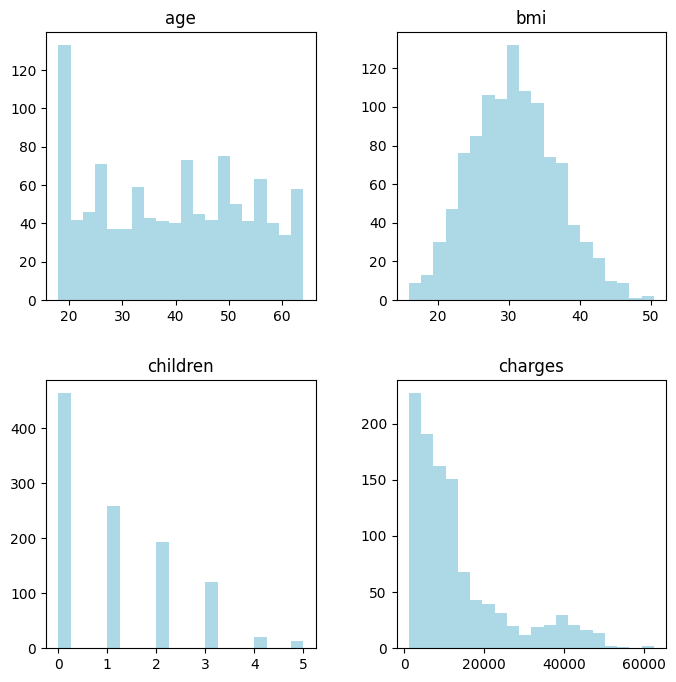

In [33]:
import matplotlib.pyplot as plt
train_data[num_cols].hist(bins=20, figsize=(8,8), color='lightblue', grid=False)
plt.show()

### Bar charts for Categorical Columns

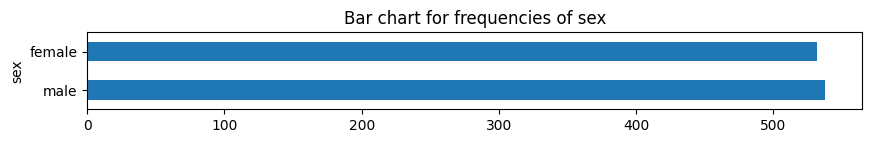

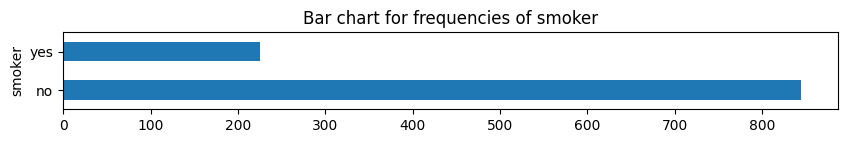

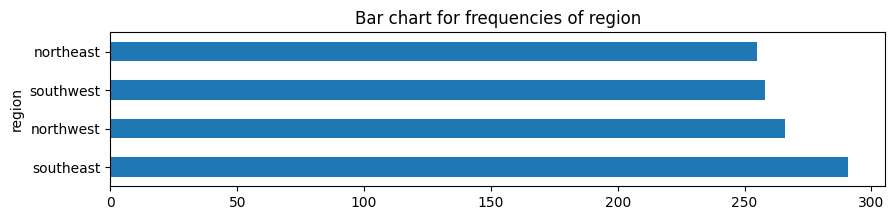

In [34]:
for col in cat_cols:
    freq_table = train_data[col].value_counts()
    plt.figure(figsize = (10,len(freq_table)*0.5)) #a bit formatting so that chart look better
    freq_table.plot.barh(title='Bar chart for frequencies of ' + col)
    plt.show()
    print()

### Data Pipeline

Now, fill in the `num_cols`, `log_cols`, `cat_cols`, and `target` with the correct columns.
- `num_cols` includes all numeric features that are symmetric
- `log_cols` includes all numeric features that are skewed
- `cat_cols` includes all categorical features
- `target` is the name of the target column

**All names should be strings**

In [35]:
num_cols = ['bmi']  #this list is for symmetric numeric columns
log_cols = ['age', 'children']  #this list is for skewed numeric columns
cat_cols = ["sex", "smoker", "region"]  #this list for the class columns
target = 'charges'    #this is the name of the target

In [36]:
#processing pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

num_pipeline = Pipeline([                           #now we need a small pipeline for numeric columns since it has two steps
    ('impute', SimpleImputer(strategy='median')),   #this step will impute missing values using column medians
    ('standardize', StandardScaler())               #this step will scale all numeric columns
])

def log_transformation(x):
    return np.log(x+0.01)

log_pipeline = Pipeline([                                        #now we need a small pipeline for numeric columns since it has two steps
    ('impute', SimpleImputer(strategy='median')),                #this step will impute missing values using column medians
    ('log transform', FunctionTransformer(log_transformation)), #this include a log transformation into the pipeline
    ('standardize', StandardScaler())                            #this step will scale all numeric columns
])

processing_pipeline = ColumnTransformer([                                                      #this transformer merges the processed numeric columns and class columns
    ('numeric', num_pipeline, num_cols),                                                       #numeric columns
    ('log', log_pipeline, log_cols),                                                           #log columns
    ('class', OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist'), cat_cols) #encoder to transform class columns to numeric, this will automatically handle missing data
  ])

processing_pipeline.fit(train_data)                            #train the pipeline
trainX = processing_pipeline.transform(train_data)             #generate the training features
trainY = train_data[target]                                    #generate the training target
testX = processing_pipeline.transform(test_data)               #generate the testing features
testY = test_data[target]                                      #generate the testing features

## Save the processing pipeline

We will save the processing pipeline to use later. Change `pipeline_save_path` to your desired Google Drive folder.

In [37]:
pipeline_save_path = '/content/drive/MyDrive/Enterprise AI/Assignment1/process_pipeline.pk'

In [38]:
import joblib

joblib.dump(processing_pipeline, pipeline_save_path)

['/content/drive/MyDrive/Enterprise AI/Assignment1/process_pipeline.pk']

## Model Training

Now, we will build a Neural Network to solve the prediction problem. Change `num_layers`, `num_iters`, and `learning_rate` to the desired numbers

In [39]:
num_layers = 4
num_iters = 400
learning_rate = 0.01

In [40]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input

neural_net = Sequential()
neural_net.add(Input(shape=(trainX.shape[1], )))
for _ in range(num_layers):
  neural_net.add(Dense(trainX.shape[1], activation='relu'))
neural_net.add(Dense(1))

neural_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')
neural_net.fit(trainX, trainY, epochs=num_iters, batch_size=int(trainX.shape[0]//10), validation_split=0.2)

Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 336883424.0000 - val_loss: 273135776.0000
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341367776.0000 - val_loss: 272920160.0000
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 330686880.0000 - val_loss: 272075808.0000
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 326481632.0000 - val_loss: 269254880.0000
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 331723584.0000 - val_loss: 260805328.0000
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 323591424.0000 - val_loss: 239005680.0000
Epoch 7/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 279529024.0000 - val_loss: 193410256.0000
Epoch 8/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 212478752.0000 - val_loss: 130250104.0000
Epoch 9/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 156914768.0000 - val_loss: 123850160.0000
Epoch 10/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 135910912.0000 - val_loss: 124753520.0000


### Evaluation

This section applies the trained model on the test data. If you like the trained model performance, continue to save it.

In [41]:
mse = neural_net.evaluate(testX, testY)
mse

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24386136.0000  


25295404.0

In [42]:
np.sqrt(mse)

5029.453648260415

# Save the trained model

You can change the parameters of the neural network and rerun the training several times. When you are happy with the model performance, we will save the model to use in the application.

Change the `model_save_path` to the correct one pointing to your desired Google Drive folder.

In [43]:
model_save_path = '/content/drive/MyDrive/Enterprise AI/Assignment1/charges_NN.keras'

neural_net.save(model_save_path)